/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.75      0.07      0.13        41
           1       0.50      0.12      0.19        42
           2       0.79      0.70      0.74        76
           3       0.89      0.85      0.87       147
           4       0.00      0.00      0.00        17
           5       1.00      0.06      0.11        17
           6       0.25      0.06      0.10        16
           7       0.90      0.88      0.89       129
           8       0.76      0.15      0.25        85
           9       0.43      0.18      0.25        90
          10       0.85      0.77      0.80       196
          11       0.66      0.36      0.46       118
          12       0.74      0.54      0.63       131
          13       0.88      0.64      0.74        72

   micro avg       0.80      0.54      0.65      1177
   macro avg       0.67      0.38      0.44      1177
weighted avg       0.76      0.54      0.60      1177
 samples avg       0.73   

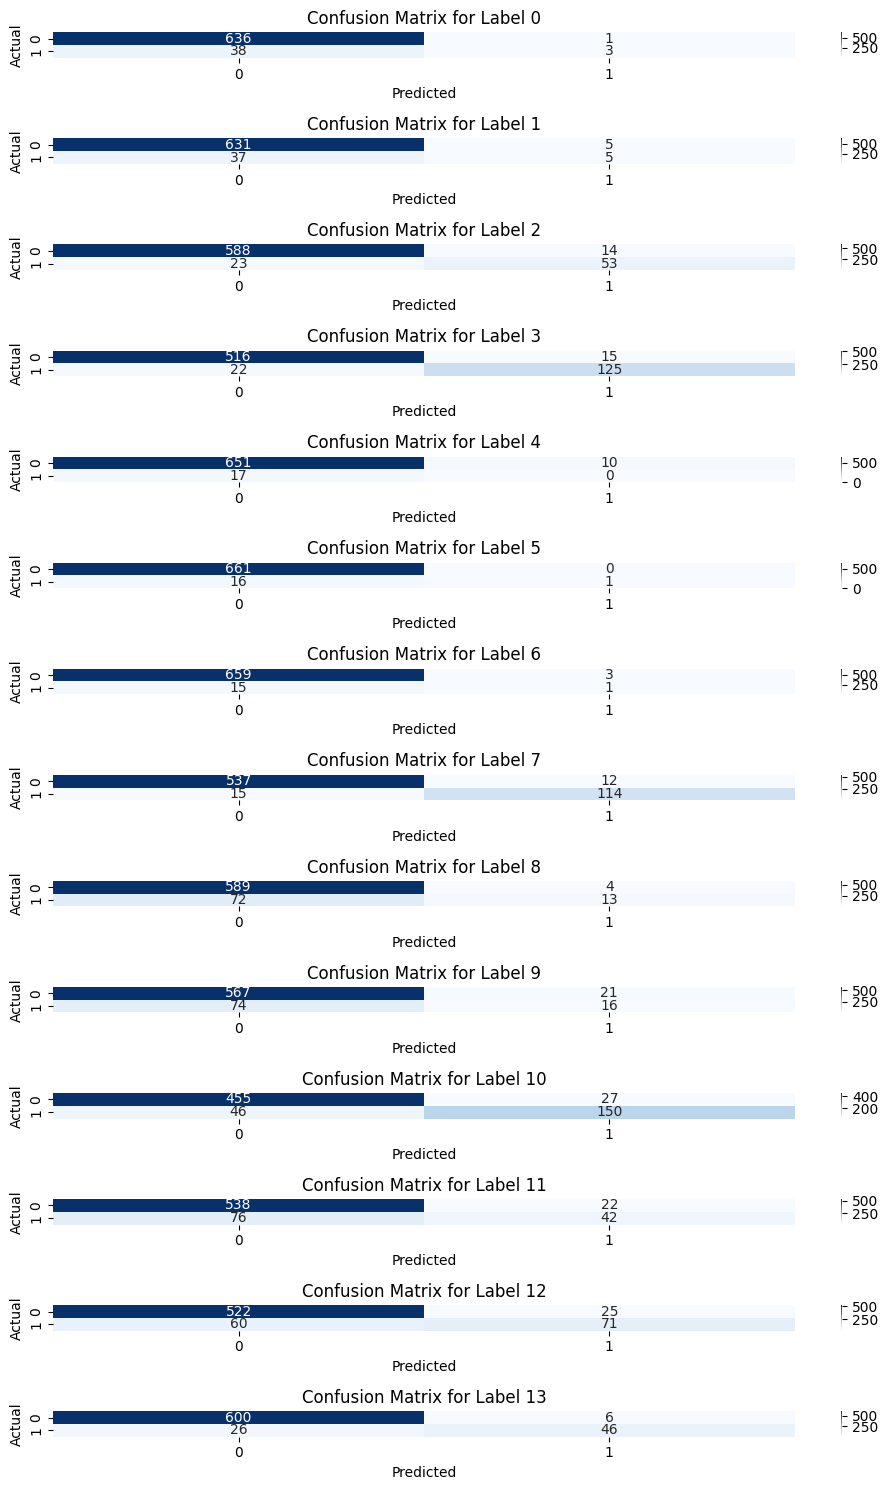

Pipeline model saved as multi_label_pipeline_model.joblib


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# データの読み込み
data = pd.read_csv('test_label_idx.csv')

# 特徴量とターゲットの設定
X = data.drop(columns=['player_positions'])

# ターゲットのマルチラベル化
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(data['player_positions'].str.split(','))

# 訓練データとテストデータに分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# カテゴリ変数の処理
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ]
)

# パイプラインの作成
base_model = GradientBoostingClassifier(random_state=42)
model = MultiOutputClassifier(base_model)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# モデルの訓練
pipeline.fit(X_train, Y_train)

# モデルの評価
y_pred = pipeline.predict(X_test)
print(classification_report(Y_test, y_pred))

# 評価指標の可視化
mcm = multilabel_confusion_matrix(Y_test, y_pred)
fig, axes = plt.subplots(len(mcm), 1, figsize=(10, 15))
for i, (ax, cm) in enumerate(zip(axes, mcm)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# モデルの保存
joblib_file = "multi_label_pipeline_model.joblib"
joblib.dump(pipeline, joblib_file)
print(f"Pipeline model saved as {joblib_file}")

### ZIP Action

In [4]:
import zipfile

with zipfile.ZipFile('multilabel_model_package.zip', 'w') as zf:
    zf.write('multi_label_pipeline_model.joblib')
    zf.write('requirements.txt')
    zf.write('pred.py')